# Tutorial Part 13: Modeling Protein-Ligand Interactions
By [Nathan C. Frey](https://ncfrey.github.io/) | [Twitter](https://twitter.com/nc_frey) and [Bharath Ramsundar](https://rbharath.github.io/) | [Twitter](https://twitter.com/rbhar90)

In this tutorial, we'll walk you through the use of machine learning and molecular docking methods to predict the binding energy of a protein-ligand complex. Recall that a ligand is some small molecule which interacts (usually non-covalently) with a protein. Molecular docking performs geometric calculations to find a “binding pose” with a small molecule interacting with a protein in a suitable binding pocket (that is, a region on the protein which has a groove in which the small molecule can rest).

The structure of proteins can be determined experimentally with techniques like Cryo-EM or X-ray crystallography. This can be a powerful tool for structure-based drug discovery. For more info on docking, read the [AutoDock Vina paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3041641/) and the [`deepchem.dock`](https://deepchem.readthedocs.io/en/latest/docking.html) documentation. There are many graphical user and command line interfaces (like AutoDock) for performing molecular docking. Here, we show how docking can be performed programmatically with DeepChem, which enables automation and easy integration with machine learning pipelines.

As you work through the tutorial, you'll trace an arc including
1. Loading a protein-ligand complex dataset ([PDBbind](http://www.pdbbind.org.cn/))
2. Performing programmatic molecular docking
3. Featurizing protein-ligand complexes with interaction fingerprints
4. Fitting a random forest model and predicting binding affinities

To start the tutorial, we'll use a simple pre-processed dataset file that comes in the form of a gzipped file. Each row is a molecular system, and each column represents a different piece of information about that system. For instance, in this example, every row reflects a protein-ligand complex, and the following columns are present: a unique complex identifier; the SMILES string of the ligand; the binding affinity (Ki) of the ligand to the protein in the complex; a Python `list` of all lines in a PDB file for the protein alone; and a Python `list` of all lines in a ligand file for the ligand alone.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Modeling_Protein_Ligand_Interactions.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()
#!/usr/local/bin/conda info -e

✨🍰✨ Everything looks OK!


In [2]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [3]:
!conda config --add channels bioconda conda-forge

usage: conda [-h] [-V] command ...
conda: error: unrecognized arguments: conda-forge


In [2]:
!conda --version

conda 23.1.0


In [4]:
!conda install -c conda-forge vina mdtraj pdbfixer openmm nglview pysam rdkit -y -q

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - mdtraj
    - nglview
    - openmm
    - pdbfixer
    - pysam
    - rdkit
    - vina


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    asttokens-2.4.1            |     pyhd8ed1ab_0          28 KB  conda-forge
    astunparse-1.6.3           |     pyhd8ed1ab_0          15 KB  conda-forge
    blosc-1.21.4               |       h0f2a231_0          48 KB  conda-forge
    boltons-23.1.1             |     pyhd8ed1ab_0         297 KB  conda-forge
    boost-1.78.0               |  py310hcb52e73_5         313 KB  conda-forge
    boost-cpp-1.78.0           

In [5]:
!pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.5/999.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 40.2 MB/s eta 0:00:00


### Protein-ligand complex data
It is really helpful to visualize proteins and ligands when doing docking. Unfortunately, Google Colab doesn't currently support the Jupyter widgets we need to do that visualization. Install [`MDTraj`](https://github.com/mdtraj/mdtraj) and [`nglview`](https://github.com/nglviewer/nglview) on your local machine to view the protein-ligand complexes we're working with.

In [1]:
import os
import numpy as np
import pandas as pd

import tempfile

from rdkit import Chem
from rdkit.Chem import AllChem
import deepchem as dc

from deepchem.utils import download_url, load_from_disk

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/usr/local/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


To illustrate the docking procedure, here we'll use a csv that contains SMILES strings of ligands as well as PDB files for the ligand and protein targets from PDBbind. Later, we'll use the labels to train a model to predict binding affinities. We'll also show how to download and featurize PDBbind to train a model from scratch.

In [2]:
data_dir = dc.utils.get_data_dir()
dataset_file = os.path.join(data_dir, "pdbbind_core_df.csv.gz")

if not os.path.exists(dataset_file):
    print('File does not exist. Downloading file...')
    download_url("https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/pdbbind_core_df.csv.gz")
    print('File downloaded...')

raw_dataset = load_from_disk(dataset_file)
raw_dataset = raw_dataset[['pdb_id', 'smiles', 'label']]

Let's see what `raw_dataset` looks like:

In [3]:
raw_dataset.head(2)

,pdb_id,smiles,label
0,2d3u,CC1CCCCC1S(O)(O)NC1CC(C2CCC(CN)CC2)SC1C(O)O,6.92
1,3cyx,CC(C)(C)NC(O)C1CC2CCCCC2C[NH+]1CC(O)C(CC1CCCCC...,8.00


### Fixing PDB files
Next, let's get some PDB protein files for visualization and docking. We'll use the PDB IDs from our `raw_dataset` and download the pdb files directly from the [Protein Data Bank](https://www.rcsb.org/) using [`pdbfixer`](https://github.com/openmm/pdbfixer). We'll also sanitize the structures with [RDKit](https://www.rdkit.org/). This ensures that any problems with the protein and ligand files (non-standard residues, chemical validity, etc.) are corrected.  Feel free to modify these cells and pdbids to consider new protein-ligand complexes. We note here that PDB files are complex and human judgement is required to prepare protein structures for docking. DeepChem includes a number of [docking utilites](https://deepchem.readthedocs.io/en/latest/api_reference/utils.html#docking-utilities) to assist you with preparing protein files, but results should be inspected before docking is attempted.

In [4]:
from openmm.app import PDBFile
from pdbfixer import PDBFixer

from deepchem.utils.vina_utils import prepare_inputs

In [5]:
#consider one protein-ligand complex for visualization
pdbid = raw_dataset['pdb_id'].iloc[1]
ligand = raw_dataset['smiles'].iloc[1]
print(pdbid)
print(ligand)

3cyx
CC(C)(C)NC(O)C1CC2CCCCC2C[NH+]1CC(O)C(CC1CCCCC1)NC(O)C(CC(N)O)NC(O)C1CCC2CCCCC2N1


In [6]:
%%time
fixer = PDBFixer(pdbid=pdbid)
PDBFile.writeFile(fixer.topology, fixer.positions, open('%s.pdb' % (pdbid), 'w'))

p, m = None, None
# fix protein, optimize ligand geometry, and sanitize molecules
try:
    p, m = prepare_inputs('%s.pdb' % (pdbid), ligand)
except:
    print('%s failed PDB fixing' % (pdbid))

if p and m:  # protein and molecule are readable by RDKit
    print(pdbid, p.GetNumAtoms())
    Chem.rdmolfiles.MolToPDBFile(p, '%s.pdb' % (pdbid))
    Chem.rdmolfiles.MolToPDBFile(m, 'ligand_%s.pdb' % (pdbid))

<timed exec>:7: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.


3cyx 1510
CPU times: user 2.92 s, sys: 42.8 ms, total: 2.97 s
Wall time: 4.04 s


### Visualization
If you're outside of Colab, you can expand these cells and use `MDTraj` and `nglview` to visualize proteins and ligands.

In [12]:
import mdtraj as md
import nglview as nv

from IPython.display import display, Image

Let's take a look at the first protein ligand pair in our dataset:

In [13]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [14]:
protein_mdtraj = md.load_pdb('3cyx.pdb')
ligand_mdtraj = md.load_pdb('ligand_3cyx.pdb')

We'll use the convenience function `nglview.show_mdtraj` in order to view our proteins and ligands. Note that this will only work if you uncommented the above cell, installed nglview, and enabled the necessary notebook extensions.

In [15]:
v = nv.show_mdtraj(ligand_mdtraj)

In [16]:
display(v)  # interactive view outside Colab

NGLWidget()

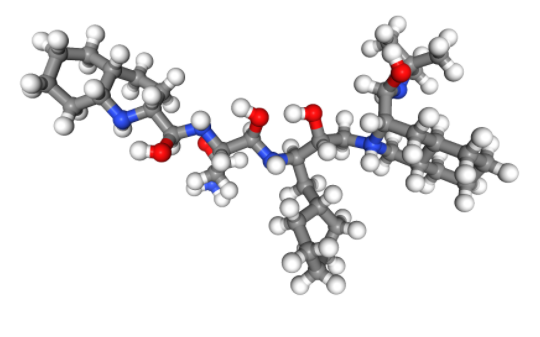

Now that we have an idea of what the ligand looks like, let's take a look at our protein:

In [17]:
view = nv.show_mdtraj(protein_mdtraj)
display(view)  # interactive view outside Colab

NGLWidget()

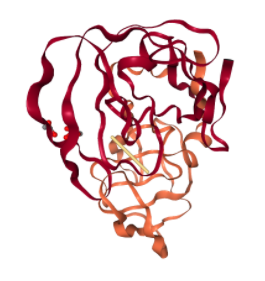

### Molecular Docking

Ok, now that we've got our data and basic visualization tools up and running, let's see if we can use molecular docking to estimate the binding affinities between our protein ligand systems.

There are three steps to setting up a docking job, and you should experiment with different settings. The three things we need to specify are 1) how to identify binding pockets in the target protein; 2) how to generate poses (geometric configurations) of a ligand in a binding pocket; and 3) how to "score" a pose. Remember, our goal is to identify candidate ligands that strongly interact with a target protein, which is reflected by the score.

DeepChem has a simple built-in method for identifying binding pockets in proteins. It is based on the [convex hull method](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4112621/pdf/1472-6807-14-18.pdf). The method works by creating a 3D polyhedron (convex hull) around a protein structure and identifying the surface atoms of the protein as the ones closest to the convex hull. Some biochemical properties are considered, so the method is not purely geometrical. It has the advantage of having a low computational cost and is good enough for our purposes.



In [7]:
finder = dc.dock.binding_pocket.ConvexHullPocketFinder()
pockets = finder.find_pockets('3cyx.pdb')
len(pockets)  # number of identified pockets

36

Pose generation is quite complex. Luckily, using DeepChem's pose generator will install the AutoDock Vina engine under the hood, allowing us to get up and running generating poses quickly.

In [8]:
vpg = dc.dock.pose_generation.VinaPoseGenerator()

We could specify a pose scoring function from `deepchem.dock.pose_scoring`, which includes things like repulsive and hydrophobic interactions and hydrogen bonding. Vina will take care of this, so instead we'll allow Vina to compute scores for poses.

In [5]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!mkdir -p vina_test

In [ ]:
%%time
complexes, scores = vpg.generate_poses(molecular_complex=('3cyx.pdb', 'ligand_3cyx.pdb'),  # protein-ligand files for docking,
                                       out_dir='vina_test',
                                       generate_scores=True
                                      )

We used the default value for `num_modes` when generating poses, so Vina will return the 9 lowest energy poses it found in units of `kcal/mol`.

In [ ]:
scores

Can we view the complex with both protein and ligand? Yes, but we'll need to combine the molecules into a single RDkit molecule.

In [ ]:
complex_mol = Chem.CombineMols(complexes[0][0], complexes[0][1])

In [ ]:
type(complex_mol)

Let's now visualize our complex. We can see that the ligand slots into a pocket of the protein.

In [ ]:
v = nv.show_rdkit(complex_mol)
display(v)

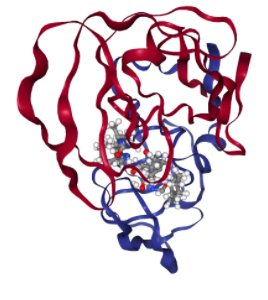

Now that we understand each piece of the process, we can put it all together using DeepChem's `Docker` class. Docker creates a generator that yields tuples of posed complexes and docking scores.

In [ ]:
docker = dc.dock.docking.Docker(pose_generator=vpg)
posed_complex, score = next(docker.dock(molecular_complex=('3cyx.pdb', 'ligand_3cyx.pdb'),
                                          use_pose_generator_scores=True))

### Modeling Binding Affinity

Docking is a useful, albeit coarse-grained tool for predicting protein-ligand binding affinities. However, it takes some time, especially for large-scale virtual screenings where we might be considering different protein targets and thousands of potential ligands. We might naturally ask then, can we train a machine learning model to predict docking scores? Let's try and find out!

We'll show how to download the PDBbind dataset. We can use the loader in MoleculeNet to get the 4852 protein-ligand complexes from the "refined" set or the entire "general" set in PDBbind. For simplicity, we'll stick with the ~100 complexes we've already processed to train our models.

Next, we'll need a way to transform our protein-ligand complexes into representations which can be used by learning algorithms. Ideally, we'd have neural protein-ligand complex fingerprints, but DeepChem doesn't yet have a good learned fingerprint of this sort. We do however have well-tuned manual featurizers that can help us with our challenge here.

We'll make use of two types of fingerprints in the rest of the tutorial, the `CircularFingerprint` and `ContactCircularFingerprint`. DeepChem also has voxelizers and grid descriptors that convert a 3D volume containing an arragment of atoms into a fingerprint. These featurizers are really useful for understanding protein-ligand complexes since they allow us to translate complexes into vectors that can be passed into a simple machine learning algorithm. First, we'll create circular fingerprints. These convert small molecules into a vector of fragments.


In [14]:
pdbids = raw_dataset['pdb_id'].values
ligand_smiles = raw_dataset['smiles'].values

In [15]:
%%time
for (pdbid, ligand) in zip(pdbids, ligand_smiles):
  fixer = PDBFixer(url='https://files.rcsb.org/download/%s.pdb' % (pdbid))
  PDBFile.writeFile(fixer.topology, fixer.positions, open('%s.pdb' % (pdbid), 'w'))

  p, m = None, None
  # skip pdb fixing for speed
  try:
    p, m = prepare_inputs('%s.pdb' % (pdbid), ligand, replace_nonstandard_residues=False,
                          remove_heterogens=False, remove_water=False,
                          add_hydrogens=False)
  except:
    print('%s failed sanitization' % (pdbid))

  if p and m:  # protein and molecule are readable by RDKit
    Chem.rdmolfiles.MolToPDBFile(p, '%s.pdb' % (pdbid))
    Chem.rdmolfiles.MolToPDBFile(m, 'ligand_%s.pdb' % (pdbid))

<timed exec>:8: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
[15:22:59] UFFTYPER: Unrecognized atom type: S_5+4 (7)
<timed exec>:8: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
<timed exec>:8: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
Exception ignored in: <function _xla_gc_callback at 0x7d3c7bad7880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
<timed exec>:8: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
<timed exec>:8: DeprecationWarning: Call to deprecated function prepare_inputs. P

3utu failed sanitization


<timed exec>:8: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
<timed exec>:8: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
<timed exec>:8: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
<timed exec>:8: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
[15:25:50] UFFTYPER: Unrecognized atom type: S_5+4 (1)
<timed exec>:8: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
<timed exec>:8: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
<timed exec>:8: DeprecationWarning: Cal

CPU times: user 5min 9s, sys: 3.14 s, total: 5min 12s
Wall time: 6min 23s


In [12]:
proteins = [f for f in os.listdir('.') if len(f) == 8 and f.endswith('.pdb')]
ligands = [f for f in os.listdir('.') if f.startswith('ligand') and f.endswith('.pdb')]

We'll do some clean up to make sure we have a valid ligand file for every valid protein. The lines here will compare the PDB IDs between the ligand and protein files and remove any proteins that don't have corresponding ligands.

In [16]:
# Handle failed sanitizations
failures = set([f[:-4] for f in proteins]) - set([f[7:-4] for f in ligands])
for pdbid in failures:
  proteins.remove(pdbid + '.pdb')

In [17]:
len(proteins), len(ligands)

(188, 188)

In [18]:
pdbids = [f[:-4] for f in proteins]
small_dataset = raw_dataset[raw_dataset['pdb_id'].isin(pdbids)]
labels = small_dataset.label

In [19]:
fp_featutirzer = dc.feat.CircularFingerprint(size=2048)

In [20]:
features = fp_featutirzer.featurize([Chem.MolFromPDBFile(l) for l in ligands])

[15:30:17] Explicit valence for atom # 7 O, 3, is greater than permitted
[15:30:17] Explicit valence for atom # 8 O, 3, is greater than permitted
Failed to featurize datapoint 68, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType, int)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)
Failed to featurize datapoint 115, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType, int)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2

An empty array is added when the molecule cannot be featurized - a simple way to deal with this is to drop datapoints corresponding to these empty arrays.

In [21]:
df = pd.DataFrame()
df['features'] = pd.Series(features)
labels.reset_index(inplace = True, drop = True)
df['labels'] = labels

In [22]:
#correcting the data shape. Required shape for sklearn models (n_samples,n_features)
empt = df['features'].apply(lambda x: True if len(x) != 0 else False)
df = df.loc[empt]
df.reset_index(inplace = True, drop = True)
df.loc[:,'features'] = df.loc[:,'features'].apply(lambda x: np.expand_dims(x, axis = 0))
df.loc[:,'labels'] = df.loc[:,'labels'].apply(lambda x: np.expand_dims(x, axis = (0,1)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
features = np.concatenate(df['features'].values, axis = 0)
labels = np.concatenate(df['labels'].values, axis = 0)
print(features.shape)
print(labels.shape)

(186, 2048)
(186, 1)


In [24]:
dataset = dc.data.NumpyDataset(X=features, y= labels, ids=pdbids)
train_dataset, test_dataset = dc.splits.RandomSplitter().train_test_split(dataset, seed=42)

The convenience loader `dc.molnet.load_pdbbind` will take care of downloading and featurizing the pdbbind dataset under the hood for us. This will take quite a bit of time and compute, so the code to do it is commented out. Uncomment it and grab a cup of coffee if you'd like to featurize all of PDBbind's refined set. Otherwise, you can continue with the small dataset we constructed above.

In [ ]:
# # Uncomment to featurize all of PDBBind's "refined" set
# pdbbind_tasks, (train_dataset, valid_dataset, test_dataset), transformers = dc.molnet.load_pdbbind(
#     featurizer=fp_featurizer, set_name="refined", reload=True,
#     data_dir='pdbbind_data', save_dir='pdbbind_data')

Now, we're ready to do some learning!

To fit a deepchem model, first we instantiate one of the provided (or user-written) model classes. In this case, we have a created a convenience class to wrap around any ML model available in Sci-Kit Learn that can in turn be used to interoperate with deepchem. To instantiate an ```SklearnModel```, you will need (a) task_types, (b) model_params, another ```dict``` as illustrated below, and (c) a ```model_instance``` defining the type of model you would like to fit, in this case a ```RandomForestRegressor```.

In [25]:
from sklearn.ensemble import RandomForestRegressor

from deepchem.utils.evaluate import Evaluator
import pandas as pd

In [26]:
seed = 42 # Set a random seed to get stable results
sklearn_model = RandomForestRegressor(n_estimators = 100, max_features = 'sqrt')
sklearn_model.random_state = seed
model = dc.models.SklearnModel(sklearn_model, use_weights = False)
model.fit(train_dataset)

Note that the $R^2$ value for the test set indicates that the model isn't producing meaningful outputs. It turns out that predicting binding affinities is *hard*. This tutorial isn't meant to show how to create a state-of-the-art model for predicting binding affinities, but it gives you the tools to generate your own datasets with molecular docking, featurize complexes, and train models.

In [27]:
# use Pearson correlation so metrics are > 0
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

evaluator = Evaluator(model, train_dataset, [])
train_r2score = evaluator.compute_model_performance([metric])
print("RF Train set R^2 %f" % (train_r2score["pearson_r2_score"]))

evaluator = Evaluator(model, test_dataset, [])
test_r2score = evaluator.compute_model_performance([metric])
print("RF Test set R^2 %f" % (test_r2score["pearson_r2_score"]))

RF Train set R^2 0.932745
RF Test set R^2 0.002978


We're using a very small dataset and an overly simplistic representation, so it's no surprise that the test set performance is quite bad.

In [28]:
# Compare predicted and true values
list(zip(model.predict(train_dataset), train_dataset.y))[:5]

[(5.825199999999994, array([5.64])),
 (4.8913666666666735, array([4.22])),
 (7.354699999999992, array([7.14])),
 (6.550400000000004, array([7.32])),
 (4.895199999999996, array([4.82]))]

In [29]:
list(zip(model.predict(test_dataset), test_dataset.y))[:5]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(6.290958333333332, array([8.85])),
 (6.8726666666666665, array([8.7])),
 (5.973756666666665, array([6.39])),
 (7.657280000000003, array([4.94])),
 (6.094900000000003, array([9.21]))]

### The protein-ligand complex view.

In the previous section, we featurized only the ligand. This time, let's see if we can do something sensible with our protein-ligand fingerprints that make use of our structural information. To start with, we need to re-featurize the dataset but using the contact fingerprint this time.

In [30]:
fp_featurizer = dc.feat.ContactCircularFingerprint(size=2048)

In [31]:
features = fp_featurizer.featurize(zip(ligands, proteins))
dataset = dc.data.NumpyDataset(X=features, y=labels, ids=pdbids)
train_dataset, test_dataset = dc.splits.RandomSplitter().train_test_split(dataset, seed=42)

[15:30:40] Explicit valence for atom # 11 C, 5, is greater than permitted
Mol [H]O[C@]1([H])C([H])([H])C([H])([H])N2[C@]1([H])[C@]([H])(C(F)(F)F)OC2([H])([H])N([H])[C@@]1([H])C([H])([H])C([H])([H])[C@]([H])(C([H])([H])N([H])[H])[C@]([H])(Cl)[C@]1([H])C([H])([H])[H] failed sanitization
[15:30:58] Explicit valence for atom # 2114 O, 3, is greater than permitted
Mol CCO.CCO.CCO.CCO.CCO.CCO.CC[C@H](C)[C@H](N)C(=O)N1CCC[C@H]1C(=O)N[C@@H](C)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)N[C@@H](CC1=CNC=N1)C(=O)N1CCC[C@H]1C(=O)NCC(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@H](C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CO)C(=O)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)NCC(=O)N[C@@H](CC(=O)O)C(=O)N[C@H](C(=O)N[C@@H](C)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@H](C(=O)N[C@@H](CO)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C(=O)NCC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@H](C(=O)N[C@@H](CCSC)C(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C

In [32]:
train_dataset

<NumpyDataset X.shape: (148, 4096), y.shape: (148, 1), w.shape: (148, 1), ids: ['2v00' '1lor' '4de2' ... '2vw5' '2y5h' '2p4y'], task_names: [0]>

Let's now train a simple random forest model on this dataset.

In [33]:
seed = 42 # Set a random seed to get stable results
sklearn_model = RandomForestRegressor(n_estimators=100, max_features='sqrt')
sklearn_model.random_state = seed
model = dc.models.SklearnModel(sklearn_model)
model.fit(train_dataset)

Let's see what our accuracies looks like!

In [34]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

evaluator = Evaluator(model, train_dataset, [])
train_r2score = evaluator.compute_model_performance([metric])
print("RF Train set R^2 %f" % (train_r2score["pearson_r2_score"]))

evaluator = Evaluator(model, test_dataset, [])
test_r2score = evaluator.compute_model_performance([metric])
print("RF Test set R^2 %f" % (test_r2score["pearson_r2_score"]))

RF Train set R^2 0.426524
RF Test set R^2 0.001281


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Ok, it looks like we have lower accuracy than the ligand-only dataset. Nonetheless, it's probably still useful to have a protein-ligand model since it's likely to learn different features than the the pure ligand-only model.

### Further reading

So far we have used DeepChem's docking module with the AutoDock Vina backend to generate docking scores for the PDBbind dataset. We trained a simple machine learning model to directly predict binding affinities, based on featurizing the protein-ligand complexes. We might want to try more sophisticated docking protocols, like the deep learning framework [gnina](https://github.com/gnina/gnina). You can read more about using convolutional neural nets for protein-ligand scoring [here](https://pubs.acs.org/doi/10.1021/acs.jcim.6b00740). And here is a [review](https://onlinelibrary.wiley.com/doi/abs/10.1002/wcms.1429) of machine learning-based scoring functions.

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!